(implementation-trpo)=
# TRPO 구현

## 구현을 위해 필요한 약간의 이론들

이번 장에서는 TRPO를 구현해볼 예정이다. TRPO 설명만큼이나 수식이 많이 나올 예정이다. 가독성과 간결성을 위하여 $\theta_{\text{old}}$를 $\bar{\theta}$으로 표기할 것이다. 먼저 지난 장에서 살펴본 surrogate objective를 적어보자.

$$
J(\theta) = \mathbb{E}_{\pi_{\bar{\theta}}}\left[\frac{\pi_{\theta}(a_t|s_t)}{\pi_{\bar{\theta}}(a_t|s_t)} \hat{A}_t \right].
$$

<br>


그리고 constraint를 포함한 최적화 문제는 다음과 같았다.

$$
\operatorname*{maximize}_{\theta} J(\theta) \; \text{ subject to } \; \bar{D}_{\text{KL}}\left(\pi_\bar{\theta} \Vert \pi_{\theta}\right) \le \delta.
$$

<br>

경사하강법을 사용하여 위의 constrained 최적화를 수행할 때는 파라미터 업데이트 방향이 일반적인 경사하강법과 다르다. 이와 관련된 내용은 natural policy gradient (NPG) 논문에 등장하며 아직 필자는 공부 전이기 때문에 정답만 말하고 갈 예정이다. Surrogate objective의 그레디언트를 $\mathbf{g}:=\nabla_\theta J(\theta)$으로 표기하고 $\pi_\theta$의 [Fisher information matrix](https://en.wikipedia.org/wiki/Fisher_information) (FIM)를 $\mathbf{F}$라고 표기할 때, 업데이트해야 할 방향은 $\mathbf{s} = \mathbf{F}^{-1}\mathbf{g}$이다. 

<br>

FIM를 계산하는 것과 그것의 역함수를 구하는 것은 시간 복잡도가 굉장히 높기 때문에 2가지 approximation을 사용할 것이다.
1. FIM을 정확히 구하는 대신 $\bar{D}_{\text{KL}}\left(\pi_\bar{\theta} \Vert \pi_{\theta}\right)$의 Hessian을 FIM의 추정치로 사용할 것이다.
2. 역함수를 계산하여 $\mathbf{F}^{-1}\mathbf{g}$을 계산하는 대신 conjugate gradient (CG)를 사용할 것이다.

<br>

---

<br>

### KL divergence와 FIM 사이의 관계

1번과 관련하여, 원래 $\pi_\theta$의 FIM은 다음과 같이 정의된다.

$$
\mathbf{F} := \mathbb{E}_{\pi_\theta}\left[ \nabla_{\theta} \log \pi_\theta(a|s) \nabla_{\theta} \log \pi_\theta(a|s) ^{\top}\right].
$$

<br>

그리고 $\bar{\theta}$가 고정되었다고 생각하고, KL divergence의 $\theta=\bar{\theta}$에서의 Taylor expansion의 $2^{\text{nd}}$-order 텀을 보면 다음과 같다. 이 또한 필자가 직접 전개를 해본 것은 아니고 [WikiPedia](https://en.wikipedia.org/wiki/Fisher_information#Relation_to_relative_entropy)를 참고하였다.


<br>

$$
\bar{D}_{\text{KL}}\left(\pi_\bar{\theta} \Vert \pi_{\theta}\right) \approx \frac{1}{2}(\theta - \bar{\theta})^{\top}\mathbf{F}(\theta - \bar{\theta}).
$$

<br>

따라서 $\theta$가 $\bar{\theta}$에 충분히 가깝다면 KL divergence를 두 번 편미분하여 FIM의 근사하는 것은 타당하다고 볼 수 있다. 따라서 TRPO에서는 KL divergence 계산을 해줘야 한다. 이산행동공간일 경우 KL divergence 계산하기 무진장 쉽다. 연속행동공간일 경우 어떤 분포로 정책을 모델링하냐에 따라서 계산이 달라진다. 우리가 사용하는 Gaussian 분포에 대해서는 다음과 같이 KL divergence 해석적으로 계산이 된다. 다음 식은 1차원 가우시안에 대해서만 정의되어 있지만, 각 행동 차원이 독립이라면 각 차원에 대해 계산하여 모두 더해주면 된다.

<br>

$$
\bar{D}_{\text{KL}}\left(\mathcal{N}(\mu_1, \sigma_1^2) \Vert \mathcal{N}(\mu_2, \sigma_2^2)\right) = \log \frac {\sigma_{2}} {\sigma_{1}} + \frac {\sigma_{1}^{2} + (\mu_{1} - \mu_{2})^{2})} {2\sigma_{2}^{2}} - \frac {1} {2}
$$

<br>

관련된 메서드를 적어보면 다음과 같다. 참고로 $\pi_{\bar{\theta}}$은 정책 학습 전에 고정되고 변하지 않아야 하기 때문에 반드시 `detach()`를 해줘야 한다.

~~~python
def gaussian_kl(self, state, old_policy, new_policy):
    mu_old, std_old = old_policy(state)
    mu_old, std_old = mu_old.detach(), std_old.detach()

    mu, std = new_policy(state)
    kl = torch.log(std / std_old) + (std_old.pow(2) + (mu_old - mu).pow(2)) / (2.0 * std.pow(2)) - 0.5
    return kl.sum(-1, keepdim=True).mean()
~~~

<br>

---

### Conjugate gradient method: 역행렬과 한 벡터의 곱 근사하는 방법

2번과 관련하여, conjugate gradient method (CGM)은 semi-positive definite 행렬 $\mathbf{F}$와 한 벡터 $\mathbf{g}$가 주어졌을 때, $\mathbf{F}\mathbf{x} = \mathbf{g}$를 만족하는 벡터 $\mathbf{x}$를 iterative하게 근사하는 방법이다. Conjugate gradient method는 굳이 행렬 $\mathbf{F}$를 알고 있지 않아도 $\mathbf{F}$와 임의의 벡터 $\mathbf{g}_k$의 곱인 $\mathbf{F}\mathbf{g}_k$ 값만 알 수 있어도 적용할 수 있는 방법이다 (여기서 아래 첨자 $k$는 iterative 횟수이다).  TRPO 구현에서는 KL divergence의 그레디언트 $\nabla_{\theta} \bar{D}_{\text{KL}}\left(\pi_\bar{\theta} \Vert \pi_{\theta}\right)$에 $\mathbf{g}_k$를 곱해주고 이들의 원소를 더해준 값을 다시 한 번 $\theta$에 대해서 그레디언트를 구하여 $\mathbf{F}\mathbf{g}_k$을 계산한다.

<br>

벡터 $\mathbf{F} \mathbf{g}$의 $i$번 째 행을 적어보면 다음과 같을 것이다.

$$
\begin{matrix}
(\mathbf{F}\mathbf{g})_i & = & \sum_{j=1}^{n} F_{ij} s_j \\
& = & \sum_{j=1}^{n} \frac{\partial^2 \bar{D}_{\text{KL}}}{\partial \theta_i \partial \theta_j} s_j \\
& = & \sum_{j=1}^{n} \frac{\partial}{\partial \theta_i} \left( \frac{\partial}{{\partial \theta_j}} \bar{D}_{\text{KL}} \right) s_j \\
& = & \frac{\partial}{\partial \theta_i} \sum_{j=1}^{n}  \frac{\partial  \bar{D}_{\text{KL}}}{{\partial \theta_j}} s_j. \\
\end{matrix}
$$

<br>

먼저, CGM 알고리즘은 행렬 $\mathbf{F}$와 주어진 벡터 $\mathbf{g}_k$의 행렬-벡터곱을 계산해주는 과정이 필요하다. 이는 다음과 같이 [dongminlee94님의 구현체](https://github.com/dongminlee94/deep_rl/blob/main/agents/trpo.py#L102)을 참고하여 구현하였다. 참고로 어떤 파라미터에 대하여 한 스칼라값을 두 번 편미분하고 싶다면 `torch.autograd.grad()` 함수에 `create_graph=True`를 넘겨줘야 한다. 그리고 파라미터 사이의 계산을 용이하게 하기 위하여 `flat_grad()` 메서드를 통해 파라미터들을 쭉 flatten 해서 사용할 것이다. 그리고 사실 `p * damping_coeff`가 있는 이유는 잘 모르겠지만, 경사하강법에서 momentum 느낌으로 너무 aggresive하게 업데이트하는 것을 완화시켜주는 역할인 것 같다. 
~~~python
def fisher_vector_product(self, state, p, damping_coeff=0.1):
    """
    Compute the multiplication of Fisher information matrix and a given vector ``p``
    by taking the Hessian of the KL divergence between old policy and current policy.
    """
    p.detach()
    kl = self.gaussian_kl(state, self.old_policy, self.policy)
    kl_grad = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
    kl_grad = self.flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p).sum()
    kl_hessian = torch.autograd.grad(kl_grad_p, self.policy.parameters())
    kl_hessian = self.flat_grad(kl_hessian, hessian=True)
    return kl_hessian + p * damping_coeff
~~~

<br>

CGM 알고리즘을 구현한 코드는 다음과 같다. 마찬가지로 필자는 이론을 공부하지 않았기 때문에 [WikiPedia](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm)와 [dongminlee94님의 구현체](https://github.com/dongminlee94/deep_rl/blob/main/agents/trpo.py#L79)를 참고하였다. 
~~~python
def conjugate_gradient(self, state, b, cg_iters=10, eps=1e-8, residual_tol=1e-10):
    x = torch.zeros_like(b)  # Initial guess x_0
    r = b.clone()  # r_0 = b - Ax_0 = b
    p = r.clone()  # p_0 = r_0

    rdotr = torch.dot(r, r)
    for _ in range(cg_iters):
        Ap = self.fisher_vector_product(state, p)
        alpha = rdotr / (torch.dot(p, Ap) + eps)

        x += alpha * p
        r -= alpha * Ap

        new_rdotr = torch.dot(r, r)
        beta = new_rdotr / rdotr
        p = r + beta * p

        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x
~~~

<br>

---

### 정책 업데이트 알고리즘

축하한다! 위 세 가지 메서드를 사용하면 파라미터 업데이트 방향 $\mathbf{s} = \mathbf{F}^{-1}\mathbf{g}$을 찾게 되었다! 이제 방향만 찾았을 뿐이다! 방향을 찾는 것을 구현해보면 다음과 같다. `learn()` 메서드 중 정책 업데이트 부분을 가져왔다. 부분 발췌를 하느라 아직까지 정의되지 않은 변수들이 있다. 앞부분이 궁금하신 분들은 아래 `TRPO` 클래스에서 찾아보면 좋을 것 같다.

~~~
# Policy loss
ratio_old = (log_prob - log_prob_old).exp()
policy_loss_old = (ratio_old * adv).mean()

# Gradient ``g`` of the surrogate objective
gradient = torch.autograd.grad(policy_loss_old, self.policy.parameters())
gradient = self.flat_grad(gradient)

# Find s = F^{-1}g using conjugate gradient method
search_dir = self.conjugate_gradient(s, gradient.data)
~~~

<br>

`ratio_old`와 `adv`와 함께 surrogate objective $J(\theta)$를 계산한 것이 `policy_loss_old`이다. 이것의 그레디언트 $\mathbf{g}:=\nabla_\theta J(\theta)$가 `gradient`에 저장된다. 그리고 CGM을 통해 $\mathbf{F}^{-1}\mathbf{g}$을 찾은 것이 `search_dir`에 저장되게 된다.

<br>

이제 해당 방향으로 딱 알맞게 이동하여 다음 파라미터를 찾는 방법인 backtrack line search에 대해 알아보도록 하겠다. Constraint를 만족할 수 있는 최대 step size가 `step_size`에 저장되어 있다. 이는 TRPO 논문 Appendix C에서 찾아볼 수 있다. 원래 FIM $\mathbf{F}$는 positive semi-definite matrix이기 때문에 모든 벡터 $\mathbf{x}$에 대하여 $\mathbf{x}^{\top} \mathbf{F} \mathbf{x} \ge 0$이 만족한다. 따라서 `gHg` 변수는 이론상 항상 0보다 크거나 같아야한다. 하지만, 우리의 구현에서는 위에서 설명한 2가지 approximation을 사용하고 있기 때문에 아주 낮은 횟수로 `gHg` 변수가 음수가 될 때가 있다 (5000번 중 1번 정도). 이러면 `step_size` 계산할 때 `torch.sqrt()`에 음수가 입력되기 때문에 `nan`이 반환되면서 에러가 발생한다. 이론이 조금 무너지더라도, `gHg`가 음수일 때 부호를 반대로 바꿔주는 코드를 추가해주었다. 

<br>

최대 step size로 업데이트할 경우 contraint만 만족하는 것이고 실제로 surrogate objective가 개선되지 않을 수 있다. Surrogate objective가 개선될 때까지 step size를 지수적으로 감소시키며 파라미터를 탐색하는 방법이 backtrack line search이다. `expected_improve`가 다소 이해가 안 되었는데, surrogate가 감소하는 방향인 $\mathbf{g}$와 실제 업데이트 방향인 $\mathbf{F}^{-1}\mathbf{g}$를 내적한 것이다. 그레디언트를 업데이트 방향에 프로젝션한 것이므로 해당 방향으로 업데이트 했을 때 surrogate function이 얼마나 증가하는지를 대략 나타내는 것 같다.

~~~python
gHg = (self.fisher_vector_product(s, search_dir) * search_dir).sum(0)
gHg = -gHg if gHg < 0 else gHg
step_size = torch.sqrt(2 * self.delta / gHg)
old_params = self.flat_params(self.policy)
self.update_model(self.old_policy, old_params)

# Backtrack line search
with torch.no_grad():
    expected_improve = (gradient * step_size * search_dir).sum(0, keepdim=True)
    for i in range(self.backtrack_iter):
        params = old_params + self.backtrack_coeff * step_size * search_dir
        self.update_model(self.policy, params)

        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_prob = m.log_prob(z).sum(dim=-1, keepdim=True)
        ratio = (log_prob - log_prob_old).exp()
        policy_loss = (ratio * adv).mean()

        loss_improve = policy_loss - policy_loss_old
        expected_improve *= self.backtrack_coeff
        improve_condition = loss_improve / expected_improve

        kl = self.gaussian_kl(s, self.old_policy, self.policy)

        if kl < self.delta and improve_condition > self.backtrack_alpha:
            break

        if i == self.backtrack_iter - 1:
            params = self.flat_params(self.old_policy)
            self.update_model(self.policy, params)
        self.backtrack_coeff *= 0.5
~~~

<br>

여기까지가 TRPO 알고리즘에 엄청나게 중요한 부분이고 나머지는 지난 장들에서 해봤던 구현 코드와 거의 똑같다. 코드를 쭉 써내려가보도록 하겠다.

<br>

---

## TRPO 구현

이번 장에서는 TRPO+GAE를 알고리즘을 `Pendulum-v1` 환경에 적용해볼 것이다. 그리고 TRPO+GAE 정도되면 슬슬 MuJoCo 환경도 제어할 수 있는 알고리즘이기 때문에 MuJoCo 환경 중 가장 쉬운 `Hopper-v4`도 제어를 해볼 예정이다. 먼저 필요한 패키지들을 불러오자

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from torch.distributions import Normal
from tqdm import tqdm

<br>

`RolloutBuffer` 및 네트워크들은 지난 장들과 동일하다.

In [2]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)


class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

<br>

### TRPO 클래스 구현

코드가 많이 길다. 그래도 한 번 따라써보면 자그마치 TRPO를 구현한 사람이 되는 것이다. 하기 싫은 마음을 한 번 꾹 참고 구현하여 TRPO를 손에 얻어내자.

In [3]:
class TRPO:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(64, 64),
        activation_fn=torch.tanh,
        batch_size=2048,
        value_lr=0.003,
        gamma=0.99,
        lmda=0.95,
        delta=0.01,
        num_value_updates=80,
        backtrack_iter=10,
        backtrack_coeff=1.0,
        backtrack_alpha=0.5
    ):
        self.gamma = gamma
        self.lmda = lmda
        self.delta = delta
        self.batch_size = batch_size
        self.num_value_updates = num_value_updates
        self.backtrack_iter = backtrack_iter
        self.backtrack_coeff = backtrack_coeff
        self.backtrack_alpha = backtrack_alpha

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.old_policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)  
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)

        self.t = 0
        self.buffer = RolloutBuffer()

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()

    def flat_grad(self, grads, hessian=False):
        grad_flatten = []
        if not hessian:
            for grad in grads:
                grad_flatten.append(grad.view(-1))
            grad_flatten = torch.cat(grad_flatten)

        else:
            for grad in grads:
                grad_flatten.append(grad.contiguous().view(-1))
            grad_flatten = torch.cat(grad_flatten).data
        return grad_flatten

    def flat_params(self, model):
        params = []
        for param in model.parameters():
            params.append(param.data.view(-1))
        params_flatten = torch.cat(params)
        return params_flatten

    def update_model(self, model, new_params):
        """
        Replace the parameters of ``model`` with ``new_params``.
        ``new_params`` should be a flattend parameters.
        """
        index = 0
        for params in model.parameters():
            params_length = len(params.view(-1))
            new_param = new_params[index: index + params_length]
            new_param = new_param.view(params.size())
            params.data.copy_(new_param)
            index += params_length

    def gaussian_kl(self, state, old_policy, new_policy):
        mu_old, std_old = old_policy(state)
        mu_old, std_old = mu_old.detach(), std_old.detach()

        mu, std = new_policy(state)
        kl = torch.log(std / std_old) + (std_old.pow(2) + (mu_old - mu).pow(2)) / (2.0 * std.pow(2)) - 0.5
        return kl.sum(-1, keepdim=True).mean()
        
    def fisher_vector_product(self, state, p, damping_coeff=0.1):
        """
        Compute the multiplication of Fisher information matrix and a given vector ``p``
        by taking the Hessian of the KL divergence between old policy and current policy.
        """
        p.detach()
        kl = self.gaussian_kl(state, self.old_policy, self.policy)
        kl_grad = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
        kl_grad = self.flat_grad(kl_grad)

        kl_grad_p = (kl_grad * p).sum()
        kl_hessian = torch.autograd.grad(kl_grad_p, self.policy.parameters())
        kl_hessian = self.flat_grad(kl_hessian, hessian=True)
        return kl_hessian + p * damping_coeff

    def conjugate_gradient(self, state, b, cg_iters=10, eps=1e-8, residual_tol=1e-10):
        x = torch.zeros_like(b)  # Initial guess x_0
        r = b.clone()  # r_0 = b - Ax_0 = b
        p = r.clone()  # p_0 = r_0

        rdotr = torch.dot(r, r)
        for _ in range(cg_iters):
            Ap = self.fisher_vector_product(state, p)
            alpha = rdotr / (torch.dot(p, Ap) + eps)

            x += alpha * p
            r -= alpha * Ap

            new_rdotr = torch.dot(r, r)
            beta = new_rdotr / rdotr
            p = r + beta * p

            rdotr = new_rdotr
            if rdotr < residual_tol:
                break
        return x

    def learn(self):
        self.policy.train()
        self.value.train()

        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])

        # Computing GAE and returns
        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)
            ret = torch.clone(r)
            adv = torch.clone(delta)
            for t in reversed(range(len(ret) - 1)):
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]

        # update value network parameter:
        for _ in range(self.num_value_updates):
            value = self.value(s)
            value_loss = F.mse_loss(value, ret)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

        # Computing old log prob
        with torch.no_grad():
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
            log_prob_old = m.log_prob(z).sum(dim=-1, keepdim=True)

        # Updating policy network
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_prob = m.log_prob(z).sum(dim=-1, keepdim=True)

        # Policy loss
        ratio_old = (log_prob - log_prob_old).exp()
        policy_loss_old = (ratio_old * adv).mean()

        # Gradient ``g`` of the surrogate objective
        gradient = torch.autograd.grad(policy_loss_old, self.policy.parameters())
        gradient = self.flat_grad(gradient)

        # Find s = F^{-1}g using conjugate gradient method
        search_dir = self.conjugate_gradient(s, gradient.data)
        gHg = (self.fisher_vector_product(s, search_dir) * search_dir).sum(0)
        # Since CG is an approximation algorithm, it fails to satisfy positive definiteness with a low probability,
        # Then, we flip the sign of gHg to prevent torch.sqrt from taking a negative value.
        gHg = -gHg if gHg < 0 else gHg
        step_size = torch.sqrt(2 * self.delta / gHg)
        old_params = self.flat_params(self.policy)
        self.update_model(self.old_policy, old_params)

        # Backtrack line search
        with torch.no_grad():
            expected_improve = (gradient * step_size * search_dir).sum(0, keepdim=True)
            for i in range(self.backtrack_iter):
                params = old_params + self.backtrack_coeff * step_size * search_dir
                self.update_model(self.policy, params)

                mu, std = self.policy(s)
                m = Normal(mu, std)
                z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
                log_prob = m.log_prob(z).sum(dim=-1, keepdim=True)
                ratio = (log_prob - log_prob_old).exp()
                policy_loss = (ratio * adv).mean()

                loss_improve = policy_loss - policy_loss_old
                expected_improve *= self.backtrack_coeff
                improve_condition = loss_improve / expected_improve

                kl = self.gaussian_kl(s, self.old_policy, self.policy)

                if kl < self.delta and improve_condition > self.backtrack_alpha:
                    break

                if i == self.backtrack_iter - 1:
                    params = self.flat_params(self.old_policy)
                    self.update_model(self.policy, params)
                self.backtrack_coeff *= 0.5

        result = {
            'Step': self.t,
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
        }

        return result

    def step(self, transition):
        result = None
        self.t += 1
        self.buffer.store(transition)
        if self.buffer.size >= self.batch_size:
            result = self.learn()

        return result

<br>

### Pendulum-v1 환경 제어

제목이 곧 내용이다! 참고로 TRPO 및 GAE 논문에서는 엄청 큰 배치 사이즈를 사용한다. 본 구현에서는 배치 사이즈 2000을 사용했지만 논문을 직접 찾아보면 더 큰 배치 사이즈에 대해서 더 많은 environment steps 동안 학습시킨다.

In [4]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [5]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
env_name = 'Pendulum-v1'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
batch_size = 2000
activation_fn = torch.tanh
gamma = 0.95
lmda = 0.95
backtrack_alpha = 0.5

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = TRPO(
    state_dim,
    action_dim,
    hidden_dims=hidden_dims,
    activation_fn=activation_fn,
    batch_size=batch_size,
    gamma=gamma,
    lmda=lmda,
    backtrack_alpha=backtrack_alpha,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [08:32<00:00, 1951.37it/s]


<br>

학습 곡선을 시각화해보면 다음과 같다. 지금까지 구현했던 알고리즘들 중 제일 빠르게 수렴했으며 수렴 성능도 더 높은 것을 알 수 있다.

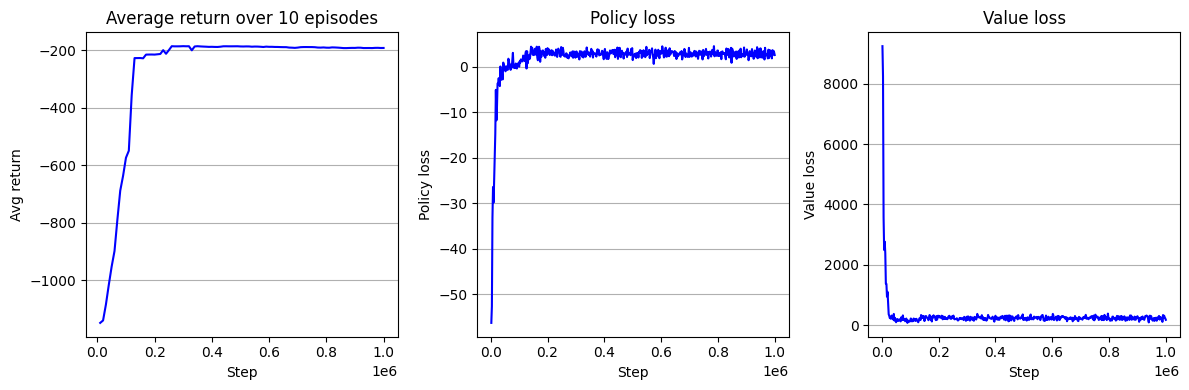

In [7]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

---

(implementation-trpo-hopper)=
### Hopper-v4 환경 제어

제목이 곧 내용이다! 참고로 위의 Pendulum-v1 코드를 그대로 가져다 쓰면 안 된다. 사소하게 변경된 지점들이 있다. Pendulum-v1의 가능한 행동 범위가 $[-2,2]$였는데 이를 위해 사용했던 `env.step(2 * a)`를 `env.step(a)`으로 바꿔줘야 한다. MuJoCo 환경들은 모두 가능한 행동 범위가 모든 차원에서 $[-1,1]$이다. 그리고 Pendulum-v1에서는 할인률 $\gamma$의 값을 0.95를 사용해줬었는데, 이를 0.99로 바꿔주었다. 학습률도 0.003에서 0.0003으로 줄여주었다.


In [8]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [9]:
env_name = 'Hopper-v4'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
value_lr = 0.0003
batch_size = 2000
activation_fn = torch.tanh
gamma = 0.99
lmda = 0.95

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = TRPO(
    state_dim,
    action_dim,
    hidden_dims=hidden_dims,
    activation_fn=activation_fn,
    batch_size=batch_size,
    value_lr=value_lr,
    gamma=gamma,
    lmda=lmda,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [13:00<00:00, 1281.97it/s]


<br>

`Hopper-v4` 환경에 대한 TRPO+GAE의 학습 곡선은 다음과 같다. 
Return 곡선만 본다면 학습이 진행될 수록 받게 되는 누적 보상이 증가하고 있다.
하지만, `Hopper-v4` 환경에 대해서 어느 정도 누적 보상을 받아야 환경을 제어하는 데 성공했다고 말할 수 있을지 그 기준을 알 수 없다.
사실 TRPO+GAE 이후에 등장한 PPO, SAC, TD3와 비교해보면 높지 않은 성능이다.

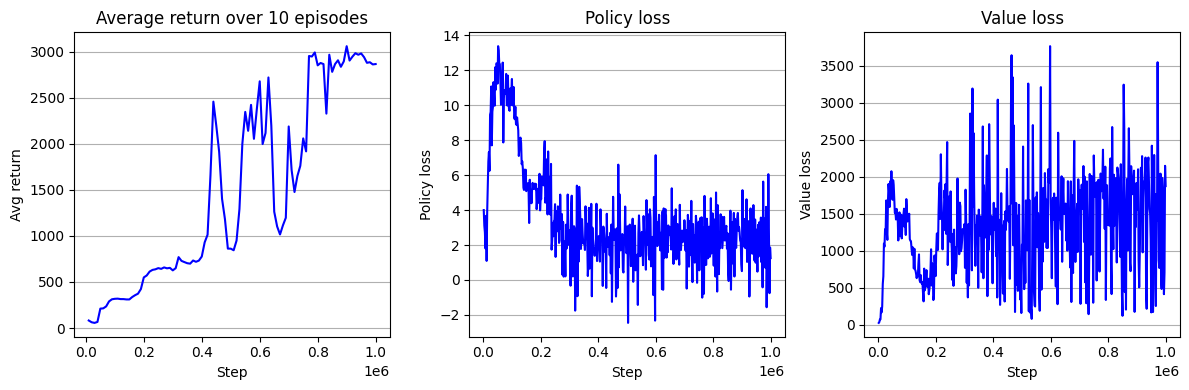

In [10]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

이것으로 TRPO+GAE 구현을 마무리했다. 다음에 알아볼 알고리즘은 TRPO의 개선체인 PPO에 대해서 알아볼 예정이다.
PPO는 TRPO을 이론적으로 개선했다기 보다는 구현적으로 개선한 알고리즘이다.

<br>

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```